# Tree generation

This application allows you to generate a dendrogram from the absence/presence matrix. You must upload a csv files where the first column contains a header called Code, and the rest of the file must contain the absence/presence matrix. 

<Figure size 3600x21600 with 0 Axes>

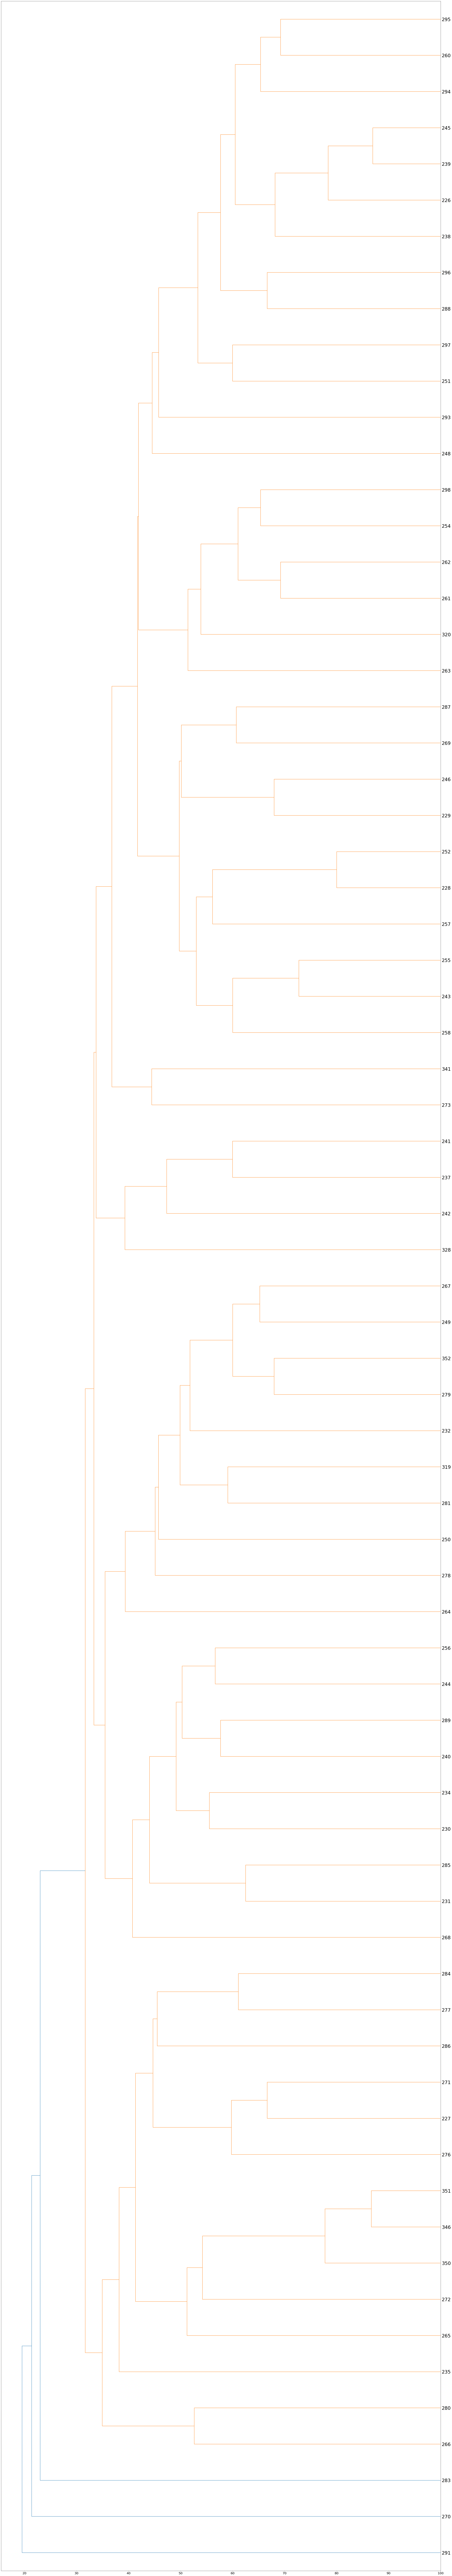

In [3]:
import numpy as np
import ipywidgets as widgets
from traitlets import dlink
import pandas as pd
from scipy.spatial.distance import pdist, jaccard
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from matplotlib import pyplot as plt
from math import log
import numpy as np
from io import StringIO
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


wt1 = widgets.Label("1. Select the similarity threshold:")
slider_picker = widgets.IntSlider(value=30,min=0,max=100,step=1)

wt2 = widgets.Label("2. Indicate the number of repetitions for bootstrapping:")
bootstrapping = widgets.BoundedIntText(value=100,min=0,max=1000)

wt3 = widgets.Label("3. Indicate if you are using a \",\" or \";\" to separte the values in your csv file:")
formato = widgets.Select(options=[';', ','],value=';')

wt4 = widgets.Label("4. Upload the csv file:")
file_picker = widgets.FileUpload(accept='*.csv')
file_name = widgets.Text()

wb = widgets.Button( description='Compute')

out = widgets.Output(layout={'border': '1px solid black'})
vbox = widgets.VBox([widgets.HBox([wt1,slider_picker]),
                     widgets.HBox([wt2,bootstrapping]),
                     widgets.HBox([wt3,formato]),
                     widgets.HBox([wt4,file_picker, file_name]),wb,out])




def process(similarity,reps,df):
  theshold = 1-(similarity*1.0/100)

  matrix = df.values[:,1:]
  clustering = AgglomerativeClustering(n_clusters=None,affinity='precomputed',linkage='average',
                                      distance_threshold=theshold)

  m = pairwise_distances(matrix, matrix, metric='jaccard')

  clustering.fit(m)

  def plot_dendrogram(model, **kwargs):
      # Create linkage matrix and then plot the dendrogram

      # create the counts of samples under each node
      counts = np.zeros(model.children_.shape[0])
      n_samples = len(model.labels_)
      for i, merge in enumerate(model.children_):
          current_count = 0
          for child_idx in merge:
              if child_idx < n_samples:
                  current_count += 1  # leaf node
              else:
                  current_count += counts[child_idx - n_samples]
          counts[i] = current_count

      linkage_matrix = np.column_stack([model.children_, model.distances_,
                                        counts]).astype(float)
      Z = np.asarray(linkage_matrix, order='c')


      # Plot the corresponding dendrogram
      plt.figure(figsize=(50, 300))

      R = dendrogram(linkage_matrix, color_threshold=model.distance_threshold, no_plot=True, **kwargs)
      return R,Z#(Z.shape()[0]+1),max(Z[:, 2])


  R,Z = plot_dendrogram(clustering,leaf_font_size=20.,  # font size for the x axis labels
      orientation='left',
      labels = df['Code'].values)


  p = [len([x for x in clustering.labels_ if x==i])*1.0/len(clustering.labels_) for i in range(0,clustering.n_clusters_)] # Shannon's index

  diversity = -sum([pi*log(pi) for pi in p])
  richness = clustering.n_clusters_ - 1.0/log(len(clustering.labels_))
  evenness = diversity / log(clustering.n_clusters_)

  def _remove_dups(L):
      """
      Remove duplicates AND preserve the original order of the elements.
      The set class is not guaranteed to do this.
      """
      seen_before = set([])
      L2 = []
      for i in L:
          if i not in seen_before:
              seen_before.add(i)
              L2.append(i)
      return L2

  def _plot_dendrogram(icoords, dcoords, ivl, p, n, mh, orientation,
                      no_labels, color_list, leaf_font_size=None,
                      leaf_rotation=None, contraction_marks=None,
                      ax=None, above_threshold_color='b'):
      # Import matplotlib here so that it's not imported unless dendrograms
      # are plotted. Raise an informative error if importing fails.
      try:
          # if an axis is provided, don't use pylab at all
          if ax is None:
              import matplotlib.pylab
          import matplotlib.patches
          import matplotlib.collections
      except ImportError:
          raise ImportError("You must install the matplotlib library to plot "
                            "the dendrogram. Use no_plot=True to calculate the "
                            "dendrogram without plotting.")

      if ax is None:
          ax = matplotlib.pylab.gca()
          # if we're using pylab, we want to trigger a draw at the end
          trigger_redraw = True
      else:
          trigger_redraw = False

      # Independent variable plot width
      ivw = len(ivl) * 10
      # Dependent variable plot height
      dvw = mh + mh * 0.05
      
      
      # Size axis y


      iv_ticks = np.arange(5, len(ivl) * 10 + 5, 10)
      if orientation in ('top', 'bottom'):
          if orientation == 'top':
              ax.set_ylim([0, dvw])
              ax.set_xlim([0, ivw])
          else:
              ax.set_ylim([dvw, 0])
              ax.set_xlim([0, ivw])

          xlines = icoords
          ylines = dcoords
          if no_labels:
              ax.set_xticks([])
              ax.set_xticklabels([])
          else:
              ax.set_xticks(iv_ticks)

              if orientation == 'top':
                  ax.xaxis.set_ticks_position('bottom')
              else:
                  ax.xaxis.set_ticks_position('top')

              # Make the tick marks invisible because they cover up the links
              for line in ax.get_xticklines():
                  line.set_visible(False)

              leaf_rot = (float(_get_tick_rotation(len(ivl)))
                          if (leaf_rotation is None) else leaf_rotation)
              leaf_font = (float(_get_tick_text_size(len(ivl)))
                          if (leaf_font_size is None) else leaf_font_size)
              ax.set_xticklabels(ivl, rotation=leaf_rot, size=leaf_font)

      elif orientation in ('left', 'right'):
          if orientation == 'left':
              ax.set_xlim([dvw, 0])
              ax.set_ylim([0, ivw])
          else:
              ax.set_xlim([0, dvw])
              ax.set_ylim([0, ivw])

          xlines = dcoords
          ylines = icoords
          if no_labels:
              ax.set_yticks([])
              ax.set_yticklabels([])
          else:
              ax.set_yticks(iv_ticks)

              if orientation == 'left':
                  ax.yaxis.set_ticks_position('right')
              else:
                  ax.yaxis.set_ticks_position('left')

              # Make the tick marks invisible because they cover up the links
              for line in ax.get_yticklines():
                  line.set_visible(False)

              leaf_font = (float(_get_tick_text_size(len(ivl)))
                          if (leaf_font_size is None) else leaf_font_size)

              if leaf_rotation is not None:
                  ax.set_yticklabels(ivl, rotation=leaf_rotation, size=leaf_font)
              else:
                  ax.set_yticklabels(ivl, size=leaf_font)
                  
              ax.tick_params(axis='x', which='minor', labelsize=20)
              ax.tick_params(axis='x', which='major', labelsize=20)
              ax.set_xticklabels(range(100,0,-10))

      # Let's use collections instead. This way there is a separate legend item
      # for each tree grouping, rather than stupidly one for each line segment.
      colors_used = _remove_dups(color_list)
      color_to_lines = {}
      for color in colors_used:
          color_to_lines[color] = []
      for (xline, yline, color) in zip(xlines, ylines, color_list):
          color_to_lines[color].append(list(zip(xline, yline)))

      colors_to_collections = {}
      # Construct the collections.
      for color in colors_used:
          coll = matplotlib.collections.LineCollection(color_to_lines[color],
                                                      colors=(color,))
          colors_to_collections[color] = coll

      # Add all the groupings below the color threshold.
      for color in colors_used:
          if color != above_threshold_color:
              ax.add_collection(colors_to_collections[color])
      # If there's a grouping of links above the color threshold, it goes last.
      if above_threshold_color in colors_to_collections:
          ax.add_collection(colors_to_collections[above_threshold_color])

      if contraction_marks is not None:
          Ellipse = matplotlib.patches.Ellipse
          for (x, y) in contraction_marks:
              if orientation in ('left', 'right'):
                  e = Ellipse((y, x), width=dvw / 100, height=1.0)
              else:
                  e = Ellipse((x, y), width=1.0, height=dvw / 100)
              ax.add_artist(e)
              e.set_clip_box(ax.bbox)
              e.set_alpha(0.5)
              e.set_facecolor('k')

      if trigger_redraw:
          matplotlib.pylab.draw_if_interactive()


  from random import choices

  def bootstrap(df,model,reps=100):
      clusters = [[df['Code'].values[j] for j in range(0,len(df['Code'].values)) if model.labels_[j]==i] for i in range(0,model.n_clusters_)]
      res = []
      for i in range(0,reps):
          codes = choices(df['Code'],k=len(matrix))
          matrixNew = np.array([list(df[df['Code']==code].values[:,1:][0]) for code in codes])
          m = pairwise_distances(matrixNew, matrixNew, metric='jaccard')
          model.fit(m)
          clustersNew = [[codes[j] for j in range(0,len(codes)) if model.labels_[j]==i] for i in range(0,model.n_clusters_)]
          res.append([max([len(set(c) & set(cN)) *1.0 / len(set(c) | set(cN)) for cN in clustersNew]) for c in clusters])
      return np.mean(np.array(res),axis=0)


  plt.figure(figsize=(50, 300))
  _plot_dendrogram(R['icoord'],R['dcoord'],R['ivl'],50, Z.shape[0]+1, max(Z[:, 2]), 'left',
                          False, R['color_list'],leaf_font_size=30)   
  plt.savefig('dendrogram.png')

  with out:
    print("Number of clusters: %d" % clustering.n_clusters_)
  clusters = [[df['Code'].values[j] for j in range(0,len(df['Code'].values)) if clustering.labels_[j]==i] for i in range(0,clustering.n_clusters_)]
  with out:
    for i,c in enumerate(clusters):
      print("Cluster %d consits of the elements: %s" % (i,c))

  res = bootstrap(df,clustering,reps)

  with out:
    print("Diversity (Shannon's index): %f" % diversity)
    print("Richness (Margalef's index): %f" % richness)
    print("Evenness (Pielou's index): %f" % evenness)

    print("Bootstrapping: (stability of clusters):")
    for i in range(0,len(clusters)):
      print("Stability of cluster %d is %f" % (i,res[i]))

  from scipy.cluster import hierarchy
  def getNewick(node, newick, parentdist, leaf_names):
      if node.is_leaf():
          return "%s:%.2f%s" % (leaf_names[node.id], parentdist - node.dist, newick)
      else:
          if len(newick) > 0:
              newick = "):%.2f%s" % (parentdist - node.dist, newick)
          else:
              newick = ");"
          newick = getNewick(node.get_left(), newick, node.dist, leaf_names)
          newick = getNewick(node.get_right(), ",%s" % (newick), node.dist, leaf_names)
          newick = "(%s" % (newick)
          return newick

  tree = hierarchy.to_tree(Z,False)
  with out:
    print("Netwick format for itol:")
    print(getNewick(tree, "", tree.dist, df['Code'].values))
    
  with out:
    file = open("dendrogram.png", "rb")
    image = file.read()
    display(widgets.Image(value=image))



# get filename from FileUpload dict
def get_name(file_upload):
    if len(file_upload) == 0:
        return ''
    return next(iter(file_upload.values()))['metadata']['name']

def compute(file_content,sl,bs,f):
    out.clear_output()
    with out:
        print("Processing this might take some time....")
    df = pd.read_csv(StringIO(file_content.data[0].decode("utf-8")), sep=f)
    similarity = sl
    reps = bs
    process(similarity,reps,df)

#def change_input(change):
#vbox.children = (widgets.HBox([file_picker, file_name]),)

# links between widgets
#dlink((file_picker, 'value'), (file_name, 'value'), get_name)
#file_picker.observe(change_input, 'value')

def on_button_clicked(b):
    global vbox, file_picker, file_name,slider_picker,bootstrapping,formato
    if len(list(file_picker.value))==0:
        print("Upload a file first")
    else:
        compute(file_picker,slider_picker.value,bootstrapping.value,formato.value)

wb.on_click(on_button_clicked)

vbox